## Lab 2. Simple text processing and gradient boosting.
This lab assigments consists of two parts:

1. Simple text classification using Bag of Words and TF-IDF.
2. Human activity classification using gradient boosting.

These tasks are independent.

_We recommend to keep the datasets on your computer because they will be used in Lab 3 as well._

Deadline: May 5th, 23:59

In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Part I: Prohibited Comment Classification (2 points)
This part of assigment is fully based on YSDA NLP_course homework. Special thanks to YSDA team for making it available on github.

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [85]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [86]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [87]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [88]:
# task: preprocess each comment in train and test
preprocess = np.vectorize(preprocess)
texts_train = preprocess(texts_train)
texts_test =  preprocess(texts_test)

In [89]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [90]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

all_uniq_words = set(' '.join(texts_train).split())
all_words = ' '.join(texts_train).split()


bow_vocabulary = [x[1] for x in sorted([(all_words.count(word), word) for word in all_uniq_words], key=lambda x: x[0])[-k:]]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [91]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>

    return np.array([text.split().count(x) for x in bow_vocabulary], 'float32')


In [92]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [93]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [94]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


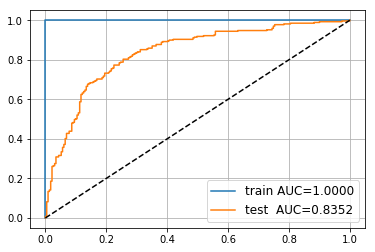

In [95]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


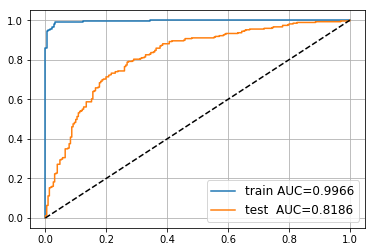

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


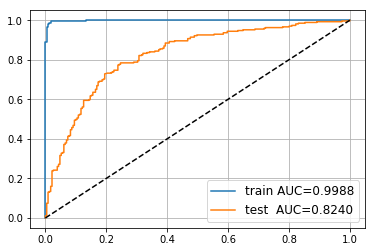

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


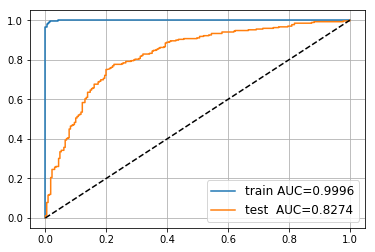

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


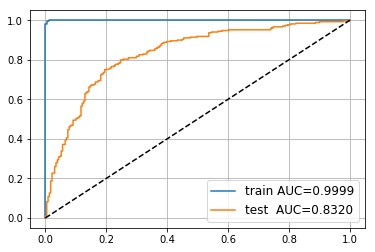

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


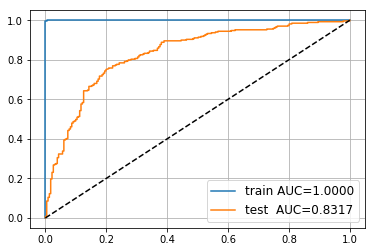

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


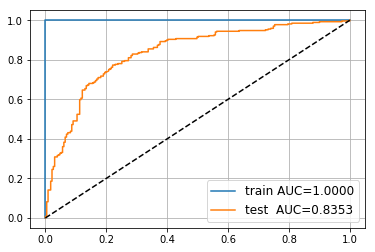

In [96]:
for k in [500, 800, 1000, 1500, 2000, 5000]:
    bow_vocabulary = [x[1] for x in sorted([(all_words.count(word), word) for word in all_uniq_words], key=lambda x: x[0])[-k:]]
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    bow_model = LogisticRegression().fit(X_train_bow, y_train)
    for name, X, y, model in [
        ('train', X_train_bow, y_train, bow_model),
        ('test ', X_test_bow, y_test, bow_model)
        ]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()
    plt.show()

#### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [97]:
import math
N = texts_train.shape

print(N)

(500,)


In [98]:
def countContains():
    contains = dict()
    for word in bow_vocabulary:
        contains[word] = np.sum([1 for x in texts_train if word in x.split()])
    return contains

In [99]:
def bootstrap():
    for k in [500, 800, 1000, 1500, 2000, 5000]:
        bow_vocabulary = [x[1] for x in sorted([(all_words.count(word), word) for word in all_uniq_words], key=lambda x: x[0])[-k:]]
        isContains = countContains()
        X_train_bow = np.stack(list(map(lambda text: text_to_bow_tf(text, isContains), texts_train)))
        X_test_bow = np.stack(list(map(lambda text: text_to_bow_tf(text, isContains), texts_test)))
        bow_model = LogisticRegression().fit(X_train_bow, y_train)
        for name, X, y, model in [
            ('train', X_train_bow, y_train, bow_model),
            ('test ', X_test_bow, y_test, bow_model)
            ]:
            proba = model.predict_proba(X)[:, 1]
            auc = roc_auc_score(y, proba)
            plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

        plt.plot([0, 1], [0, 1], '--', color='black',)
        plt.legend(fontsize='large')
        plt.grid()
        plt.show()

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


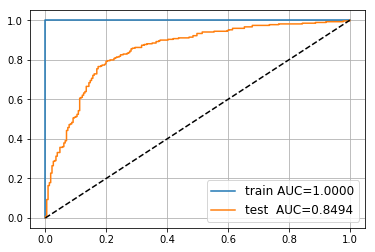

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


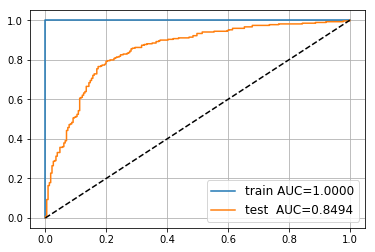

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


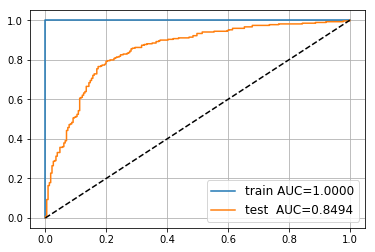

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


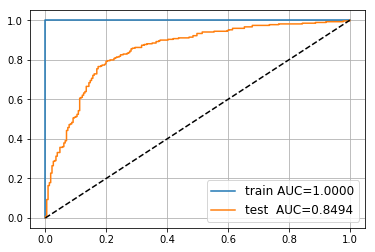

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


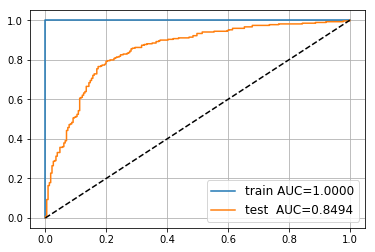

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


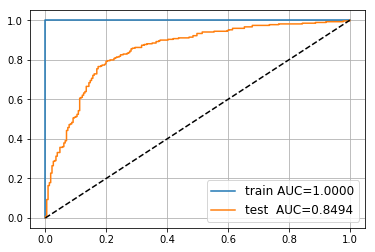

In [100]:
def text_to_bow_tf(text, isContains, alpha = 1.0):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>

    return np.array([
                    text.split().count(x) * math.log(N / (alpha + isContains[x]))
                     for x in bow_vocabulary], 'float32')


bootstrap()

**Вывод:** TF-IDF уже на маленьком наборе слов в словаре показал качество лучше, чем максимальное нами используемое количество на обычной модели. Давать каждому слову какой-то вес, помогает улучшить качество модели

### Part 2: gradient boosting (4 points)

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

First you are required to choose one of the main gradient boosting frameworks:
1. LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). One of the most popular frameworks these days that shows both great quality and performance.
2. xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
3. Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features. It's quite new, but if you wish to use it - you are welcome.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 85% accuracy on test dataset.

In [59]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [60]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [61]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [62]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [63]:
unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [64]:
pca = PCA(0.99)

In [65]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [66]:
X_train_pca.shape

(7352, 179)

In [67]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

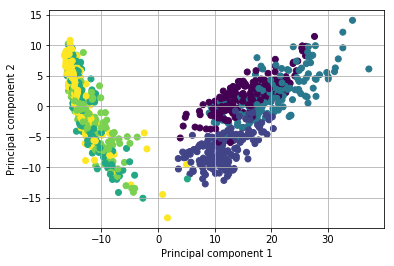

In [68]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

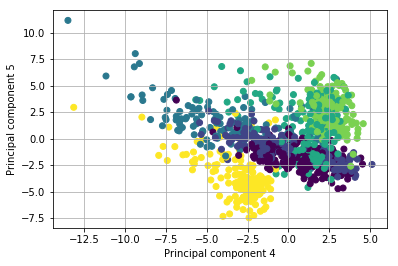

In [69]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

In [78]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import sklearn.metrics

parameters = {'booster':('gbdt', 'dart'),
              'learning_rate': np.linspace(0.0001, 0.032, 5),
              'max_depth': [3, 5, 6],
              'reg_lambda': np.linspace(0.0, 1.5, 3)
             }
clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=3, n_jobs=-1)

clf.fit(X_train_pca, y_train)



### Example: https://rpubs.com/burakh/har_xgb

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(7352, 179), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64)

[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  7.1min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  7.1min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.0min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.0min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed: 15.5min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 15.7min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 23.6min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 23.8min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed: 23.9min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 49.4min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 49.9min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 50.0min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed: 58.0min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 58.2min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 58.4min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 66.4min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 66.5min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 66.6min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 68.1min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 68.1min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 159 tasks      | elapsed: 68.2min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 69.3min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed: 69.5min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed: 69.5min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed: 70.7min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed: 70.7min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 70.9min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 72.0min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 227 tasks      | elapsed: 72.1min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed: 72.1min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 73.4min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4900,), dtype=int64).
Pickling array (shape=(2452,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed: 73.4min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float64).
Pickling array (shape=(4904,), dtype=int64).
Pickling array (shape=(2448,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed: 73.5min
Memmapping (shape=(7352, 179), dtype=float64) to old file /dev/shm/joblib_memmapping_folder_4189_4209173217/4189-139964209725000-2d432c778b5e4b8faec2036c2b4a2356.pkl
Pickling array (shape=(7352,), dtype=float

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'booster': ('gbtree', 'gblinear'), 'learning_rate': array([0.0001 , 0.00807, 0.01605, 0.02402, 0.032  ]), 'max_depth': [3, 5, 6], 'reg_lambda': array([0.  , 0.75, 1.5 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)

In [79]:
print(y_test, clf.predict(X_test_pca))

[5. 5. 5. ... 2. 2. 2.] [5. 5. 5. ... 2. 2. 2.]


In [81]:
print(clf.best_params_)

{'booster': 'gblinear', 'learning_rate': 0.032, 'max_depth': 3, 'reg_lambda': 0.0}


In [83]:
print(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test_pca)))

0.9358669833729216


**Вывод**: Разобрался в основах рабты с xgboost, изучил имеющиеся параметры. Результат хороший для подобранных параметров. Они
отличается от дефолтных 